# Full estimation with split solar gains

## Import needed libraries

In [2]:
from modestpy import Estimation
import data_importer as data
import fmpy
import pandas as pd
import os
from plotly.subplots import make_subplots
import csv

## Import data
Use the import function for the weather data to import the other data:

<table style="float:left">
<thead>
  <tr>
    <th>Data</th>
    <th>Variable name</th>
    <th>File name</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td>External temperatures</td>
    <td>weather</td>
    <td>weather.csv</td>
  </tr>
  <tr>
    <td>Solar radiation</td>
    <td>solar_rad</td>
    <td>solar_rad.csv</td>
  </tr>
  <tr>
    <td>System temperatures</td>
    <td>riser_CE</td>
    <td>riser_CE.csv</td>
  </tr>
  <tr>
    <td>Occupant count</td>
    <td>occupants</td>
    <td>occupants.csv</td>
  </tr>
  <tr>
    <td>Indoor temperatures</td>
    <td>temps</td>
    <td>temps_CE.csv</td>
  </tr>
</tbody>
</table>

In [3]:
data_path = f"Data/"

# Import external temperature time series from weather data (weather.csv)
weather = pd.read_csv(os.path.join(data_path,"weather.csv"),index_col=0)
weather.index = pd.to_datetime(weather.index)

# Import occupant time series (occupants.csv)
occupants = pd.read_csv(os.path.join(data_path,"occupants.csv"),index_col=0)
occupants.index = pd.to_datetime(occupants.index)

# Import indoor temperature time series (temps_CE.csv)
temps = pd.read_csv(os.path.join(data_path,"temps_CE.csv"),index_col=0)
temps.index = pd.to_datetime(temps.index)

# Import indoor temperature time series (avg_co2.csv)
avg_co2 = pd.read_csv(os.path.join(data_path,"avg_co2.csv"),index_col=0)
avg_co2.index = pd.to_datetime(avg_co2.index)

## Group and clean data
Here we group the data into a variables used by ModestPy. We will not go through these - just execute the cells.

### Inputs

In [66]:
%%capture
inp = pd.DataFrame(index = weather.index)
inp["time"] = weather.index

inp["solrad"] = weather["solar_rad"]

inp["Tout"] = weather["temp"]

inp["Tvestp"] = data.create_ventilation_stp(weather)["Tvest"]+1

inp["verate"] = data.create_ventilation_rate(inp.index,4,19)

inp["occ"] = occupants["inhouse"]*0.2107
inp["occ"] = inp["occ"]
inp["qrad"] = 1

inp = inp.reset_index(drop=True)
dates_inp = inp["time"]
inp["time"] = inp["time"].diff().astype('timedelta64[s]').astype('float').cumsum().fillna(0)
inp = inp.set_index("time")

inp = inp.fillna(method="bfill")

### Ideals

In [67]:
ideal = pd.DataFrame(index = temps["avg"].index)
ideal["time"] = temps["avg"].index

ideal["T"] = temps["avg"]
ideal["CO2"] = avg_co2["IC_CE"]


ideal = ideal.reset_index(drop=True)

ideal["time"] = ideal["time"].diff().astype('timedelta64[s]').astype('float').cumsum().fillna(0)
ideal = ideal.set_index("time")

ideal=ideal.fillna(method="bfill")

## Specify 'est' and 'known'
Here we define the known parameters and bounds for the estimated parameters.

In [74]:
known = {
         'Vi': 9839,
         'CO2n': 415, 
         'Vinf': 100
        }

est =   {
         'shgc': [30, 20, 50],
         'RExt': [2, 0.5, 5],
         'imass':[14,10,18],
         'maxHeat':[1000,0,20000],
         'maxVent':[33992*0.226,33992*0.1,33992]
        }


ic_param = {
    "TairInit":"T",
    "CO2Init":"CO2"
}

## Plot inputs
Plot the inputs in a graph to test if data import is successful.

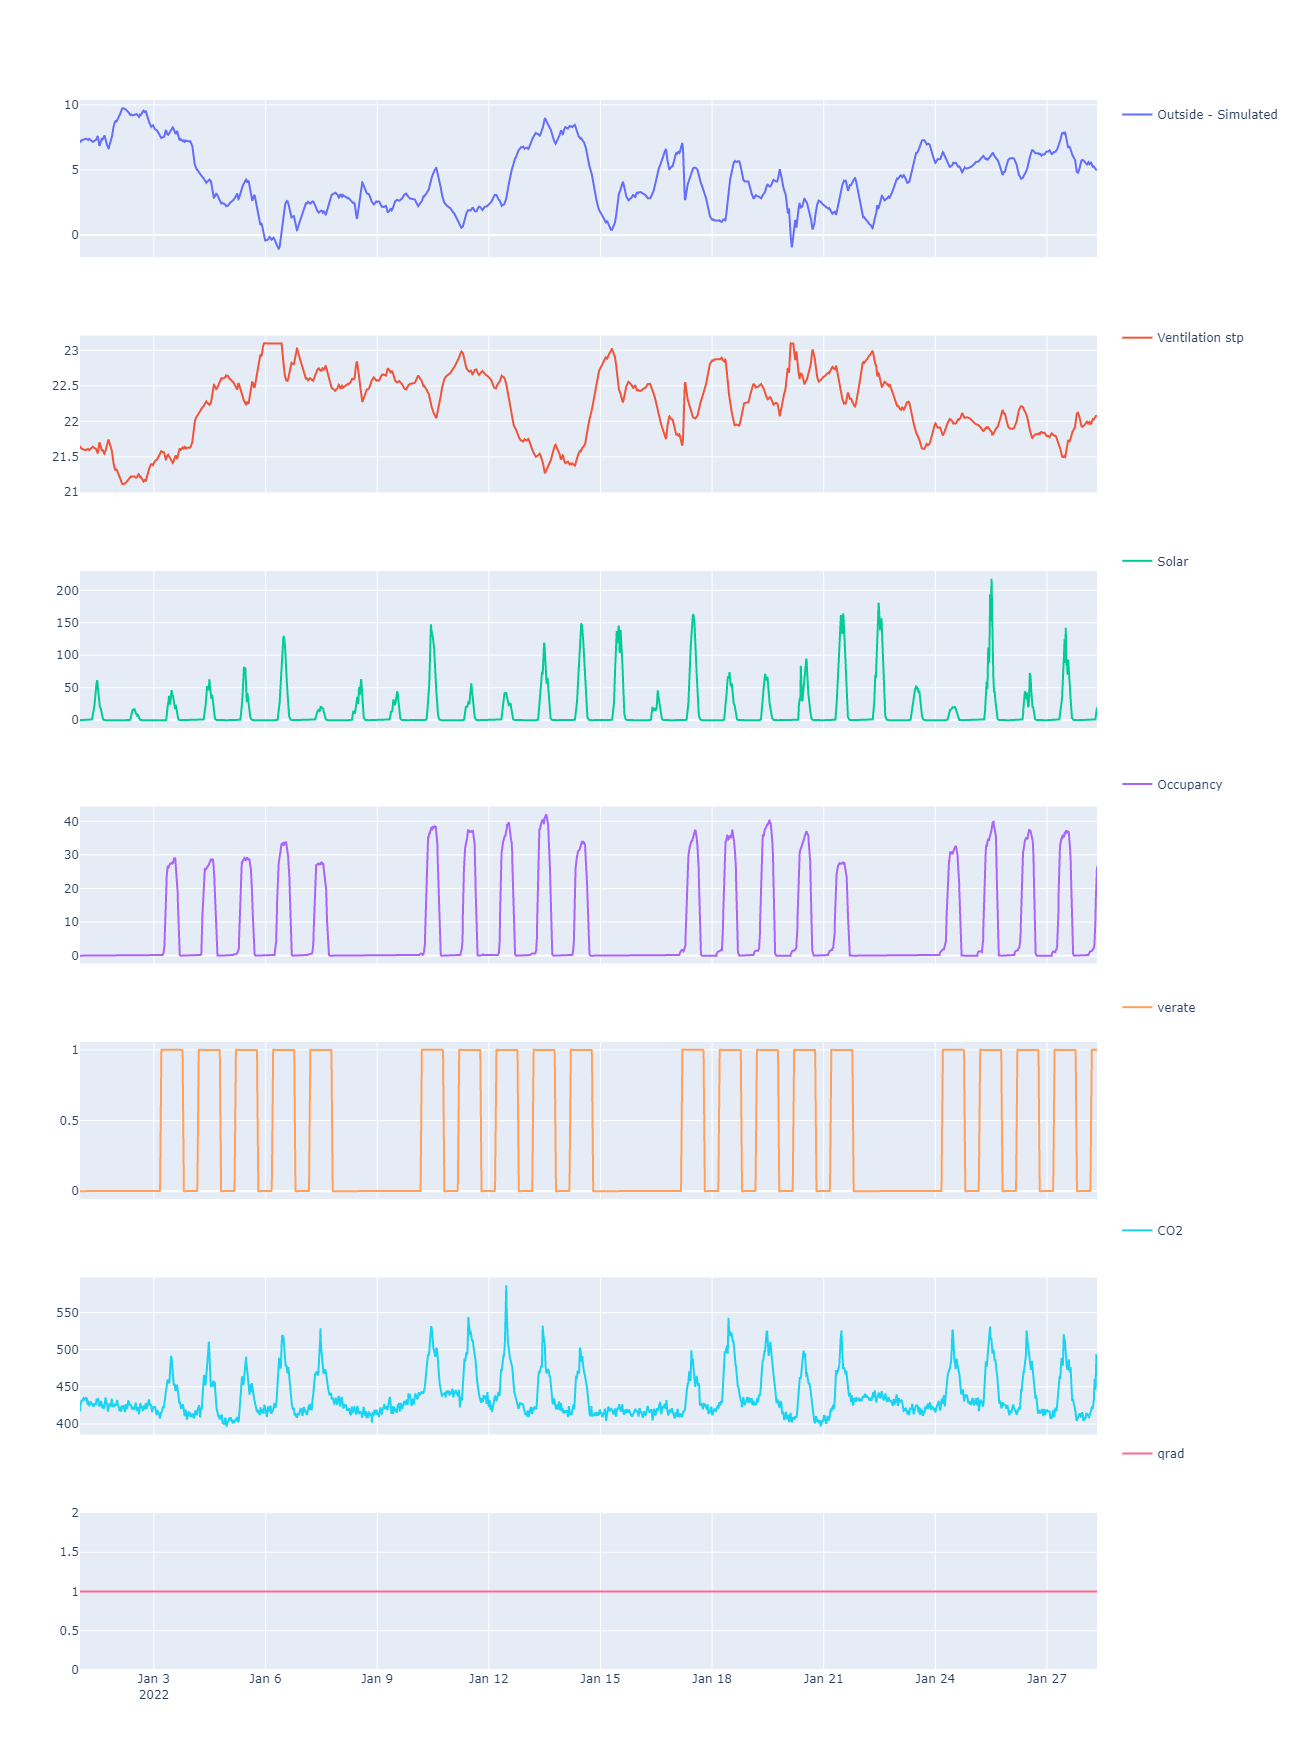

In [75]:
fig = make_subplots(rows=7, cols=1,
                    shared_xaxes = True,
                    vertical_spacing=0.05,
                   )
row = 0
# Outside temperature
row += 1
fig.add_scatter(x= dates_inp, y=inp["Tout"],row=row,col=1,name = "Outside - Simulated",legendgroup=str(row))

# Ventilation setpoint
row += 1
fig.add_scatter(x= dates_inp, y=inp["Tvestp"],row=row,col=1,name = "Ventilation stp",legendgroup=str(row))

# Solar gains
row += 1
fig.add_scatter(x= dates_inp, y=inp["solrad"],row=row,col=1,name = "Solar",legendgroup=str(row))

# Occupancy
row += 1
fig.add_scatter(x= dates_inp, y=inp["occ"],row=row,col=1,name = "Occupancy",legendgroup=str(row))

# verate
row += 1
fig.add_scatter(x= dates_inp, y=inp["verate"],row=row,col=1,name = "verate",legendgroup=str(row))

# co2
row += 1
fig.add_scatter(x= dates_inp, y=ideal["CO2"],row=row,col=1,name = "CO2",legendgroup=str(row))

# qrad
row += 1
fig.add_scatter(x= dates_inp, y=inp["qrad"],row=row,col=1,name = "qrad",legendgroup=str(row))

fig.update_layout(
    # width=800,
    height=250*row,
    legend_tracegroupgap = 250*245/300,)

fig.update_xaxes()
fig.show()

## Estimation with ModestPy
Use the following parameters to setup and start an estimation case study, based on the previous parameter estimation example:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg" style="float:left">
<thead>
  <tr>
    <th class="tg-0pky">Variable</th>
    <th class="tg-0pky">Value</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0pky">ic_param</td>
    <td class="tg-0pky">ic_param</td>
  </tr>
  <tr>
    <td class="tg-0pky">lp_n</td>
    <td class="tg-0pky">1</td>
  </tr>
  <tr>
    <td class="tg-0pky">lp_frame</td>
    <td class="tg-0pky">(start, end)</td>
  </tr>
  <tr>
    <td class="tg-0pky">vp</td>
    <td class="tg-0pky">(end, end + validation)</td>
  </tr>
  <tr>
    <td class="tg-0pky">ftype</td>
    <td class="tg-0pky">'NRMSE'</td>
  </tr>
  <tr>
    <td class="tg-0pky">default_log</td>
    <td class="tg-0pky">True</td>
  </tr>
  <tr>
    <td class="tg-0pky">logfile</td>
    <td class="tg-0pky">'simple.log'</td>
  </tr>
  <tr>
    <td class="tg-0pky">methods</td>
    <td class="tg-0pky">('MODESTGA',)</td>
  </tr>
  <tr>
    <td class="tg-0pky">generations</td>
    <td class="tg-0pky">40</td>
  </tr>
  <tr>
    <td class="tg-0pky">pop_size</td>
    <td class="tg-0pky">40</td>
  </tr>
  <tr>
    <td class="tg-0pky">trm_size</td>
    <td class="tg-0pky">7</td>
  </tr>
  <tr>
    <td class="tg-0pky">tol</td>
    <td class="tg-0pky">1e-3</td>
  </tr>
  <tr>
    <td class="tg-0pky">workers</td>
    <td class="tg-0pky">3</td>
  </tr>
</tbody>
</table>

In [76]:
# Parameters
fmu_path = "FMUs/Simple_Model.fmu"
workdir = f"Results/Simple_Model"

if not os.path.exists(workdir):
  os.makedirs(workdir)

start = 0              # Start of learning period
end = 3600*24*14       # End of learning period
validation = 3600*24*7 # Length of validation period

In [77]:
# Setup estimation
from modestpy import Estimation
session = Estimation(
        workdir,
        fmu_path,
        inp,
        known,
        est,
        ideal,
        ic_param=ic_param,
        lp_n=1,
        # lp_len=600000,
        lp_frame=(start, end),
        vp=(end, end + validation),
        methods=('MODESTGA',),
        modestga_opts={
            'generations': 15,   # Max. number of generations
            'pop_size': 40,      # Population size
            'trm_size': 7,       # Tournament size
            'tol': 1e-3,         # Absolute tolerance
            'workers': 3         # Number of CPUs to use
        },
        ftype='NRMSE',
        default_log=True,
        logfile='simple.log'
    )

C:\Users\evifj\Miniconda3\envs\lbforsikring\lib\site-packages\modestpy\estim\ga_parallel\ga_parallel.py:316: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\evifj\Miniconda3\envs\lbforsikring\lib\site-packages\modestpy\estim\ga_parallel\ga_parallel.py:454: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\evifj\Miniconda3\envs\lbforsikring\lib\site-packages\modestpy\estim\ga_parallel\ga_parallel.py:454: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\evifj\Miniconda3\envs\lbforsikring\lib\site-packages\modestpy\estim\ga_parallel\ga_parallel.py:454: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\evifj\Miniconda

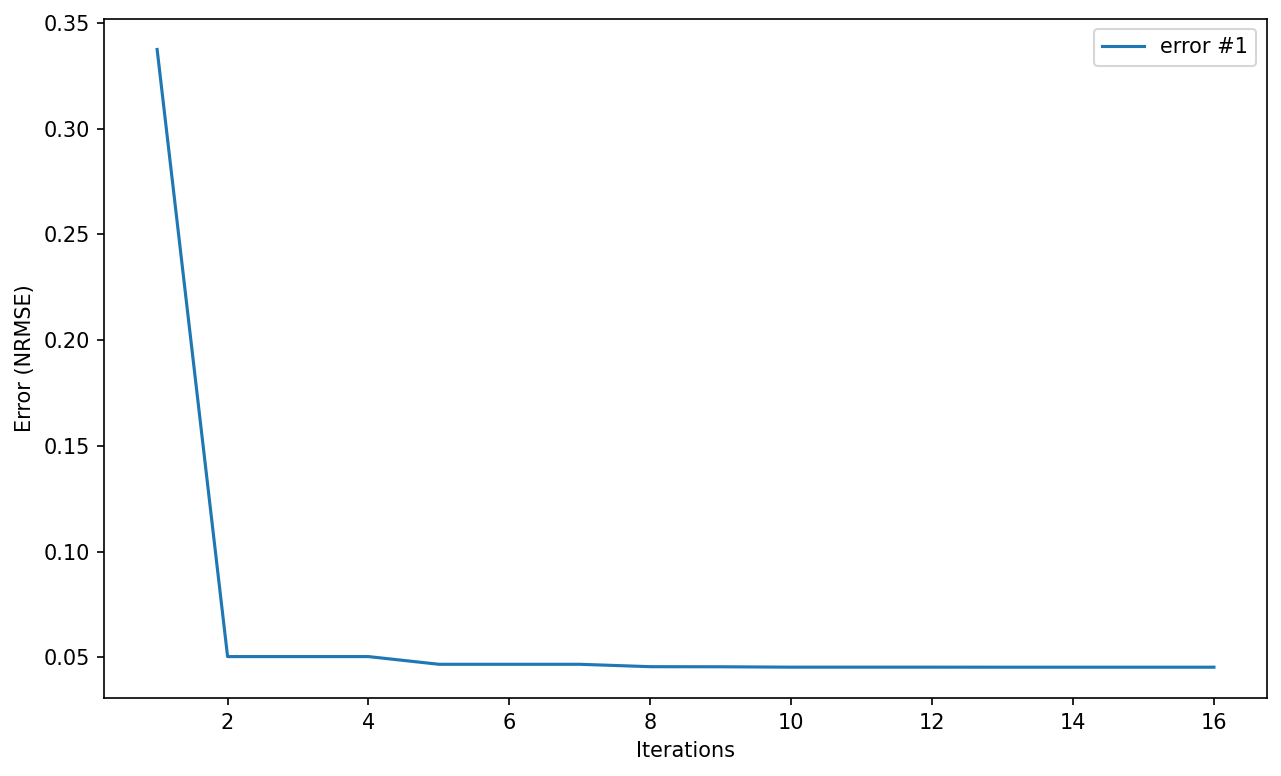

In [78]:
# Run estimation
estimates = session.estimate()

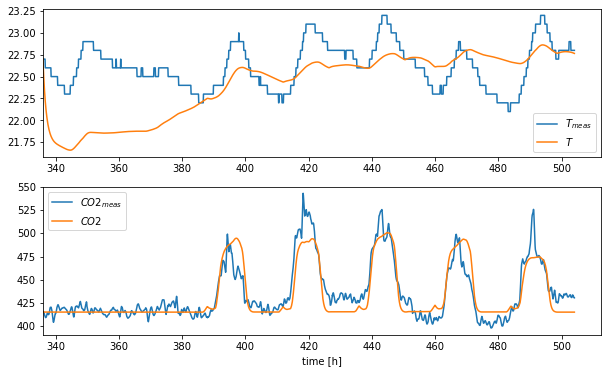

In [79]:
# Validate solution
err, res = session.validate()

In [80]:
# Print estimates
print(estimates)

{'shgc': 34.30037605110501, 'RExt': 1.5424513365097277, 'imass': 13.075118091708298, 'maxHeat': 17001.178175941863, 'maxVent': 18403.280230499706}


## Simulate, analyze and plot estimated solution
Run a simulation for the entire data period and plot the results

In [81]:
# Rewrite inputs to FMPy format
inp_copy = inp.copy()
inp_np = inp_copy.to_records()
wanted_outputs = ["T","Tout","Tret","Tsup","P_temp.y","heatFlowSensor.Q_flow","prescribedHeatFlow.Q_flow","re.port_b.Q_flow","occ","Tstp","filter1.y","verate","filter2.y","solarGainNorth.Q_flow","solarGainSouth.Q_flow","solarGainEast.Q_flow","solarGainWest.Q_flow","rad.Q_flow","airMix.port_b.Q_flow","rad.m_flow","max1.y"]

# Combine known and estimates to 'values' variable
est_path = f"Results/final.csv"
if 'estimates' in locals():
    values = {**known, **estimates}
else:
    reader = csv.DictReader(open(est_path))
    dictobj = next(reader) 
    dictobj
    values = {**known,
              **dictobj}
    
start_time = 0
stop_time = inp.index[-1]
result_realistic=fmpy.simulate_fmu(fmu_path,input=inp_np,start_values=values,output = wanted_outputs,start_time = start_time,stop_time=stop_time,relative_tolerance=1e-5)

### Clean and analyse data

In [84]:
result_df = pd.DataFrame.from_records(result_realistic, index = "time")
measured_df = pd.concat((ideal,inp),axis=1)

result_df.index = result_df.index/3600
measured_df.index = measured_df.index/3600

result_df["TimeDelta"] = result_df.index.to_series().diff() # Timestep in Hours
measured_df["TimeDelta"] = measured_df.index.to_series().diff() # Timestep in Hours

### Plot simulation results

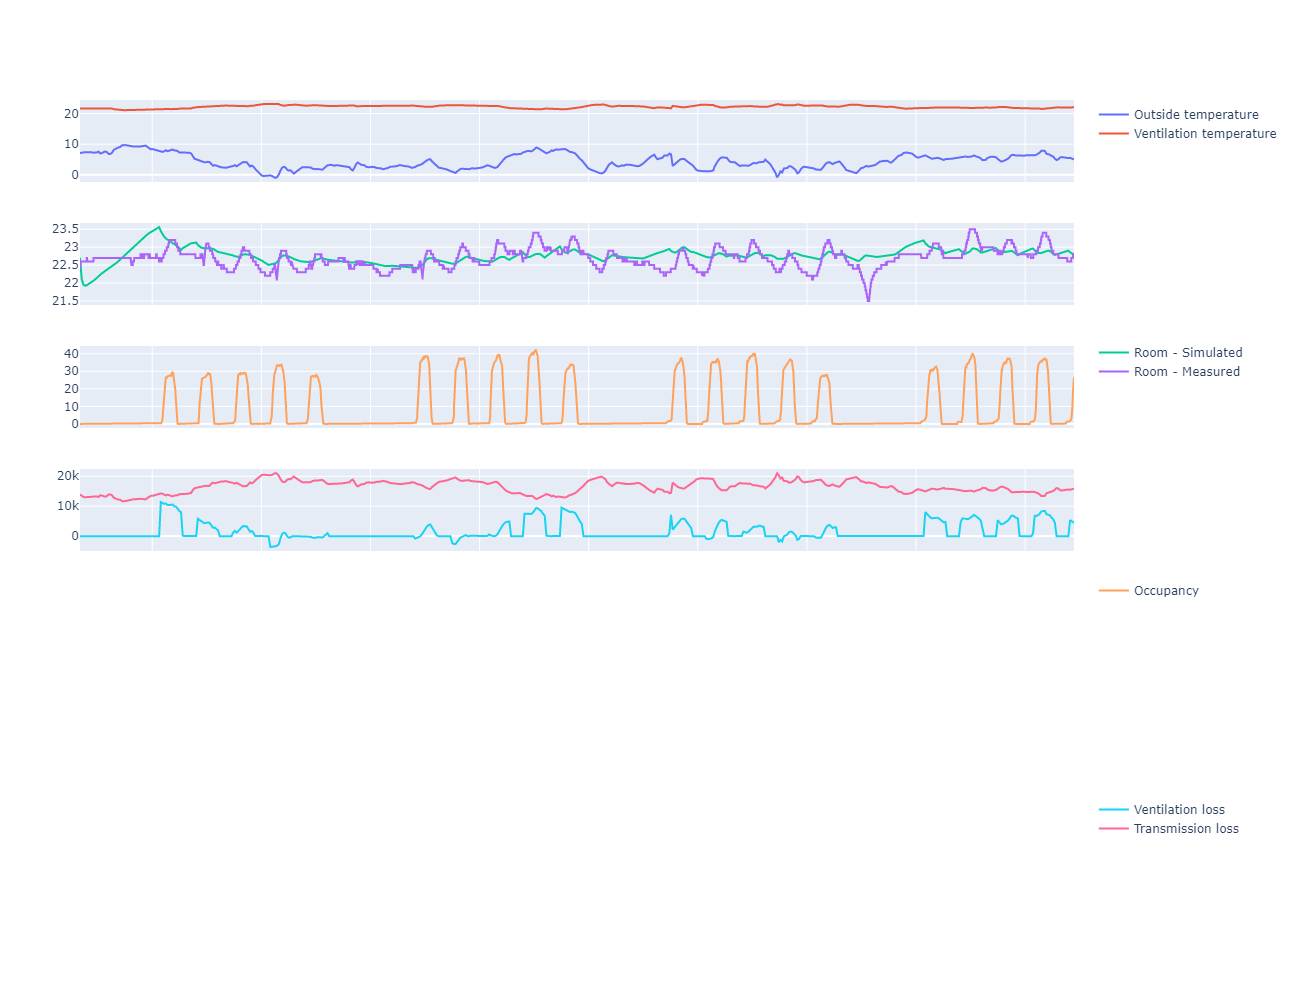

In [86]:
dates_result = pd.to_timedelta(result_df.index,'h')+dates_inp[0]

fig = make_subplots(rows=7, cols=1,
                    shared_xaxes = True,
                    vertical_spacing=0.05,
                    # subplot_titles = ["Room temperature","System temperatures","Occupancy","Solar gains","TRV","Ventilation","Damping","verate"]
                   )


# Outside temperature
row = 1
fig.add_scatter(x= dates_result, y=result_df["Tout"],row=row,col=1,name = "Outside temperature",legendgroup=str(row))
fig.add_scatter(x= dates_result, y=result_df["max1.y"]-273.15,row=row,col=1,name = "Ventilation temperature",legendgroup=str(row))

# Room temperature
row += 1
fig.add_scatter(x= dates_result, y=result_df["T"],row=row,col=1,name = "Room - Simulated",legendgroup=str(row))
fig.add_scatter(x= dates_inp, y=measured_df["T"],row=row,col=1,name = "Room - Measured",legendgroup=str(row))


# Occupancy
row += 1
fig.add_scatter(x= dates_inp, y=measured_df["occ"],row=row,col=1,name = "Occupancy",legendgroup=str(row))


# ventilation gain
row += 1
fig.add_scatter(x= dates_result, y=result_df["airMix.port_b.Q_flow"],row=row,col=1,name = "Ventilation loss",legendgroup=str(row))
fig.add_scatter(x= dates_result, y=result_df["re.port_b.Q_flow"],row=row,col=1,name = "Transmission loss",legendgroup=str(row))

fig.update_layout(
    # width=800,
    height=250*row,
    legend_tracegroupgap = 250*240/300,)

fig.show()